In [1]:
from pairs_helper_functions import *


In [70]:
def scale_size(total_size:float, num_orders:int):
    step = total_size / num_orders * 1.725
    prices = list()
    for i in range(num_orders):
        value = step + i*step
        prices.append(value)
        step -= step/num_orders
    return prices
a = scale_size(10,20)
print(a)
print(sum(a))

[0.8625, 1.6387500000000002, 2.33521875, 2.95794375, 3.5125582031250002, 4.0043163515625, 4.438117289648438, 4.818527343046875, 5.1498010978813475, 5.4359011588747554, 5.6805167110241195, 5.88708095506136, 6.058787482917316, 6.198605655600023, 6.309295042307167, 6.393418976204596, 6.453357279106514, 6.491318204277729, 6.509349643734056, 6.509349643734056]
97.64471353810586


In [4]:
import ccxt
ftx =  ccxt.ftx({
                            'apiKey': "b2aqGzkAAbBrs8qxEVswYZNbMCLmCeV_MeJhT8-e",
                            'secret': "FTgEkFA3MHIANWYZ_qMinrkzN-wmEQ4xg4jlcXFN",
                            'hostname': 'ftx.us',
                            'name': 'FTXUS',
                            'enableRateLimit': True,
                        })

In [155]:
markets = {"SOL": -.3, "ETH":.5, "BTC":.5, "AVAX":-.7}

In [156]:
last_prices = dict()
for i in markets.keys():
    s = i + "/USD:USD"
    last = markets.query("symbol == @s")
    print(last['info'])
    # last_prices[last['name']] = (last['last'], last['minProvideSize'])

AttributeError: 'dict' object has no attribute 'query'

In [149]:
a = pd.DataFrame(o.ftx.fetch_balance()['info']['result'])


In [ ]:
import pandas as pd
from oms import OMS
import time


o = OMS()
def balance():
    df = pd.DataFrame(o.ftx.fetch_balance()['info']['result'])
    sum = 0
    for i in df['usdValue']:
        sum += float(i)
    return sum

def last_prices():
    mkts = pd.DataFrame(o.ftx.fetch_markets())
    last_prices = dict()
    for i in markets.keys():
        s = i + "/USD:USD"
        last = mkts.query("symbol == @s")['info'].iloc[0]
        last_prices[i] = (last['last'], last['minProvideSize'])
    return last_prices

# get balance * lev -> multiply by weights to get dollar value/token
# calc amount to purchase
pos = o.positions()
print(pos)
markets = {"GAL": -.5, "UST":-.5}
# pos = o.positions()
lev = 2
lp = last_prices()
value = balance()
size = dict()
acc_val = balance()

curr_lev = pos['notional'].sum() / acc_val

net_lev = 0.0
for i in pos.iterrows():
    if i[1]['side'] == "short":
        net_lev -= i[1]['notional'] / value
    else:
        net_lev += i[1]['notional'] / value

    

print(net_lev)

# calculate desired size
for k,v in markets.items():
    notional = v*value*lev
    amt = notional / float(lp[k][0])
    sz = int(amt / float(lp[k][1])) * float(lp[k][1])
    size[k] = sz

sz_pd = pd.DataFrame([[k,v] for k,v in size.items()], columns=["ticker","size"])
print(curr_lev)

def size(row):
    if row['side'] == "short":
        return -row['contracts']
    else:
        return row['contracts']

def rm_suffix(row):
    return row['symbol'].removesuffix("/USD:USD")
    

pos['current_size'] = pos.apply (lambda row: size(row), axis=1)

pos['ticker'] = pos.apply (lambda row: rm_suffix(row), axis=1)

# sz_pd['current_size'] = pos['contracts'] if pos['side'] == "long" else -pos['contracts']
curr = pd.DataFrame()
curr['curr_size'] = pos.apply (lambda row: size(row), axis=1)
curr['ticker'] = pos.apply (lambda row: rm_suffix(row), axis=1)



# sz_pd['order_size'] = sz_pd['size'] - sz_pd['current_size']

final = pd.merge(sz_pd, curr, on="ticker", how="left").fillna(0)
final['diff'] = final['size'] - final['curr_size']
print(final)
# o.twap_df(final)
# print(pos.apply (lambda row: size(row), axis=1))
    






In [1]:
import pandas as pd
from oms import OMS
import time
o = OMS()
def last_prices(markets):
    mkts = pd.DataFrame(o.ftx.fetch_markets())
    last_prices = dict()
    for i in markets:
        s = i + "/USD:USD"
        last = mkts.query("symbol == @s")['info'].iloc[0]
        last_prices[i] = (last['last'], last['minProvideSize'])
    return last_prices
    
last_prices(["SOL","ETH","BTC"])

{'SOL': ('44.77', '0.01'),
 'ETH': ('1927.6', '0.001'),
 'BTC': ('31616.0', '0.001')}

In [ ]:
market_returns,pct = multi_weighted_index({"SOL":1, "ETH":-1}, 1, resolution="5m")
# b,mrk, pct_s = multi_weighted_index({"NEAR":-.25,"SOL":-.2, "AVAX":-.25,"ATOM":-.25}, 30, resolution="1h")

In [5]:
t = get_historical_data("2022-03-21", "SOL-PERP", "1h")


In [7]:
len(pct), len(t[:1467])

(1467, 1467)

In [ ]:
t_df = pd.DataFrame(t[:1467], columns=["time", "open" ,"high", "low", "close","volume"])
t_df['returns'] = (t_df['close'] - t_df['close'][0]) / t_df['close'][0]

bdf = pd.DataFrame(columns=["market","ticker"])
bdf["ticker"] = t_df['returns']
bdf["market"] = pct

def calc_beta(df):
    np_array = df.values
    s = np_array[:,0] 
    m = np_array[:,1]

    covariance = np.cov(s,m) 
    beta = covariance[0,1]/covariance[1,1]
    return beta

def rolling(df, period, function , min_periods=None):
    if min_periods is None:
        min_periods = period
    result = pd.Series(np.nan, index=df.index)

    for i in range(1, len(df)+1):
        df2 = df.iloc[max(i-period, 0):i,:] #I edited here
        if len(df2) >= min_periods:
            idx = df2.index[-1]
            result[idx] = function(df2)
    return result

bdf['beta'] = rolling(bdf, 4, calc_beta, min_periods=None)
bdf['market'].plot()


In [ ]:
bdf['index'] = bdf["market"] - bdf["ticker"]
bdf['ticker'].plot()

In [ ]:
a= compare("2022-06-01", "NEAR-PERP" , long=False)

In [ ]:
import ccxt
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
pd.options.plotting.backend = "plotly"
ftx =  ccxt.ftx({
                            'apiKey': os.getenv('API_KEY'),
                            'secret': os.getenv('API_SECRET'),
                        })

positions = pd.DataFrame(ftx.fetch_positions())
# positions[['symbol','notional',
#            'unrealizedPnl','contracts',
#            'markPrice', 'percentage', 'liquidationPrice',
#            'side',
#           ]]


: 

In [2]:
from termcolor import colored
p = positions[positions['notional'] > 0][['symbol','notional','side','contracts']]
total = p['notional'].sum()
p['weight'] = round(p['notional'] / total * 100,2)
print(colored("hi"), "cyan")
for i in p.sort_values(by=["weight"]).iterrows():
    print(f"{i[1]['symbol'].removesuffix('/USD:USD')} {i[1]['side']} {i[1]['contracts']} contracts ({i[1]['notional']}$) weight: {i[1]['weight']}")

NameError: name 'positions' is not defined

In [36]:
import pandas as pd
df = pd.read_csv("../data/Binance_ETHUSDT_1h.csv")

In [68]:
import pandas_ta as ta
import plotly.express as px


In [49]:
df = df[df['date'] > "2020-01-01"]
df['hma_200'] = df.ta.hma(length=200)

/var/folders/x4/v6qr377j3bbc576wq6903mvm0000gn/T/ipykernel_7073/2608586351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hma_200'] = df.ta.hma(length=200)


In [82]:
data = df[212:]
data['pct_dev'] = round(100*((data['hma_200'] - data['close']) / data['close'] ),4)


/var/folders/x4/v6qr377j3bbc576wq6903mvm0000gn/T/ipykernel_7073/57468003.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount,hma_200,pct_dev
212,1.650773e+12,2022-04-24 04:00:00,ETH/USDT,2955.93,2958.85,2948.62,2951.22,5937.2522,1.754233e+07,10974.0,2932.351310,-0.6394
213,1.650769e+12,2022-04-24 03:00:00,ETH/USDT,2932.34,2960.00,2930.01,2955.92,10693.1294,3.153426e+07,17028.0,2933.264941,-0.7664
214,1.650766e+12,2022-04-24 02:00:00,ETH/USDT,2928.01,2939.54,2922.77,2932.35,7467.4838,2.189809e+07,13130.0,2934.120668,0.0604
215,1.650762e+12,2022-04-24 01:00:00,ETH/USDT,2935.74,2942.49,2928.00,2928.01,8482.2448,2.490662e+07,13327.0,2934.902416,0.2354
216,1.650758e+12,2022-04-24 00:00:00,ETH/USDT,2933.04,2945.73,2930.40,2935.74,9451.5633,2.777303e+07,15840.0,2935.644091,-0.0033
...,...,...,...,...,...,...,...,...,...,...,...,...
20451,1.577851e+09,2020-01-01 04-AM,ETH/USDT,130.20,130.74,130.15,130.20,3347.0900,4.363809e+05,NaN,127.890402,-1.7739
20452,1.577848e+09,2020-01-01 03-AM,ETH/USDT,130.85,130.89,129.94,130.20,4691.4500,6.112795e+05,NaN,127.896096,-1.7695
20453,1.577844e+09,2020-01-01 02-AM,ETH/USDT,130.64,130.98,130.35,130.85,7500.5700,9.805787e+05,NaN,127.903092,-2.2521
20454,1.577840e+09,2020-01-01 01-AM,ETH/USDT,128.87,130.65,128.78,130.64,11128.4800,1.446168e+06,NaN,127.911104,-2.0889


In [87]:
print(f"mean of : {data['pct_dev'].mean()}")
print(f"std of : {data['pct_dev'].std()}")
sd_3 = data[abs(data['pct_dev']) > 13.5]

mean of : 0.0753152637818613
std of : 4.505967800252646


In [88]:
sd_3

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount,hma_200,pct_dev
1523,1.646053e+12,2022-02-28 13:00:00,ETH/USDT,2635.17,2640.66,2607.38,2617.56,19329.1270,5.070913e+07,33441.0,3010.124473,14.9973
1524,1.646050e+12,2022-02-28 12:00:00,ETH/USDT,2640.55,2665.79,2626.26,2635.17,22281.6042,5.899453e+07,37118.0,3005.630287,14.0583
1525,1.646046e+12,2022-02-28 11:00:00,ETH/USDT,2640.28,2646.97,2621.40,2640.54,10942.4077,2.885083e+07,21717.0,3000.400211,13.6283
1527,1.646039e+12,2022-02-28 09:00:00,ETH/USDT,2625.34,2642.58,2612.36,2612.39,13837.9246,3.641220e+07,28080.0,2987.984275,14.3774
1528,1.646035e+12,2022-02-28 08:00:00,ETH/USDT,2635.32,2658.00,2617.00,2625.34,19087.8620,5.032814e+07,36982.0,2980.936928,13.5448
...,...,...,...,...,...,...,...,...,...,...,...,...
19460,1.581419e+09,2020-02-11 11-AM,ETH/USDT,221.09,222.80,221.00,222.60,12281.4000,2.723713e+06,NaN,254.169108,14.1820
19461,1.581415e+09,2020-02-11 10-AM,ETH/USDT,221.23,222.20,220.31,221.09,12456.7500,2.756914e+06,NaN,253.054858,14.4578
19462,1.581412e+09,2020-02-11 09-AM,ETH/USDT,220.60,222.32,220.00,221.23,21006.5000,4.648261e+06,NaN,251.917242,13.8712
19463,1.581408e+09,2020-02-11 08-AM,ETH/USDT,218.61,220.60,218.23,220.60,14283.7700,3.130295e+06,NaN,250.759171,13.6714


In [ ]:
btc = get_historical_data("2021-01-01", "BTC-PERP", "1d")

In [26]:
import heapq
x = [1,2,3]
heapq.heapify(x)
heapq.heappush(x,9)
heapq.heappush(x,4)
heapq.nlargest(2,x)

[9, 4]

[1, 2, 3, 9, 4]

In [20]:
def lengthOfLongestSubstring( s: str) -> int:
    a,b = 0,1
    longest = 1
    substring = set()
    while b != len(s):
        if s[a] == s[b]:
            a += 1
            b += 1
        else:
            # found starting point len >= 2
            tmp = len(substring)
            substring.add(s[a])
            substring.add(s[b])
            print(tmp, len(substring), longest)
            if tmp != len(substring) and tmp > longest:
                longest = tmp
                substring.clear()
                a = b
            if tmp > longest:
                longest = tmp
            b += 1
           
        
    return longest
            
        

In [21]:
print(lengthOfLongestSubstring("abcabcbb"))

0 2 1
2 3 1
0 2 2
2 3 2
3 3 2
3 3 3
3


In [4]:
import pyportfolioopt

ModuleNotFoundError: No module named 'pyportfolioopt'

In [1]:
from pypfopt.expected_returns import mean_historical_return

ModuleNotFoundError: No module named 'pypfopt'

In [1]:
!pip3 install cmake

  Using cached cmake-3.22.5-py2.py3-none-macosx_10_10_universal2.macosx_10_10_x86_64.macosx_11_0_arm64.macosx_11_0_universal2.whl (75.2 MB)


In [3]:
!pip3 install PyPortfolioOpt

  Using cached pyportfolioopt-1.5.3-py3-none-any.whl (61 kB)
     |████████████████████████████████| 18.1 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 17.6 MB 24.9 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1


In [47]:
import yfinance as yf
data = yf.download("TSLA QQQ SPY AAPL COST UNH MSFT AMZN", period="3y", interval="1d")
# data = yf.download("SPY AAPL COST UNH", start="2022-01-01", end="2022-07-17")


[*********************100%***********************]  8 of 8 completed


In [58]:
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions

# Read in price data
df = data["Adj Close"].dropna(how="all")

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)


# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))


ef.add_objective(objective_functions.L2_reg)

# ef.efficient_return(target_return=.1, market_neutral=True)
ef.max_sharpe()
# ef.min_volatility()


weights = ef.clean_weights()
print(weights)
ef.portfolio_performance(verbose=True)
# pd.Series(weights).plot.pie(figsize=(10,10));

OrderedDict([('AAPL', 0.18403), ('AMZN', -0.07544), ('COST', 0.10511), ('MSFT', 0.05632), ('QQQ', -0.00631), ('SPY', -0.0154), ('TSLA', 0.63527), ('UNH', 0.11643)])
Expected annual return: 105.4%
Annual volatility: 50.3%
Sharpe Ratio: 2.06


/opt/homebrew/anaconda3/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


(1.0541914667520973, 0.5029905318862573, 2.0560853558690084)

In [42]:
s = sum([abs(i) for i in weights.values()])
weight = {k:round(v/s,2) for k,v in weights.items()}
weight

{'RAY-USD': 0.15, 'SOL-USD': -0.5, 'SRM-USD': 0.35}

In [14]:
from pairs_helper_functions import *


In [ ]:
def multi_weighted_index(weights, lookback_window = 30, resolution="1h", starting_balance = 1000):
    """
    Multiweighted index visualizer
    weights - dictionary of tickers with respective weights (negative weight indicates short)
    lookback_window - lookback period in days
    starting_balance - starting balance
    """
    start_date = date.today() - timedelta(lookback_window)
    ohlc_data = dict()
    holding = dict()
    for ticker, weight in weights.items():
        try:
            ohlc = read_historical_data(start_date, f"{ticker}-PERP", resolution)
        except FileNotFoundError as e:
            ohlc_filename = download_historical_data(start_date, f"{ticker}-PERP", resolution)
            ohlc = read_historical_data(start_date, f"{ticker}-PERP", resolution)
        
        holding[ticker] = weight * starting_balance / ohlc['open'][0]
        ohlc['return'] = (ohlc['close'] - ohlc['open'][0]) / ohlc['open'][0]
        if holding[ticker] < 0:
            ohlc['value'] = weight * starting_balance * (-1/ohlc['return'])
            ohlc['pnl'] = ohlc['value'] + weight*starting_balance

        else:
            ohlc['value'] = weight * starting_balance * ohlc['return']
            ohlc['pnl'] = ohlc['value'] - weight*starting_balance

        ohlc_data[ticker] = ohlc
    windowlength = len(list(ohlc_data.values())[0]) - 1
    va = [0]*(windowlength)
    plt.figure(figsize=(15,10))
    for k,v in ohlc_data.items():
        for i in range(len(va)):
            va[i] += v['pnl'][i]
        plt.plot(v['return'], label = k)
    pct_return = [(i/starting_balance) + 1 for i in va]
    print(ohlc)

    
    plt.plot(pct_return, color='black', label='return')
    plt.legend()
    print(f"min drawdown: {round(100*(min(pct_return) - 1),2)}%")
    print(f"max return: {round(100*(max(pct_return) - 1),2)}%")
    print(f"current return: {round(100*(pct_return[-1] - 1),2)}%")
    for k,v in weights.items():
        print(f"{k} : {v}")


    return ohlc_data, va

market_returns,pct = multi_weighted_index({ "BTC":-.5, "ETH":.5}, 1, resolution="1h", starting_balance=1)

0   -0.038002
dtype: float64


,ETH,ETC,cum_returns
0,-0.018948,-0.019054,-0.038002
1,-0.011344,0.012849,NaN
2,-0.014410,0.002260,NaN
3,-0.006684,-0.004287,NaN
4,-0.010302,-0.010410,NaN
...,...,...,...
141,0.085173,0.041970,NaN
142,0.090508,0.046148,NaN
143,0.089833,0.042299,NaN
144,0.088239,0.038066,NaN


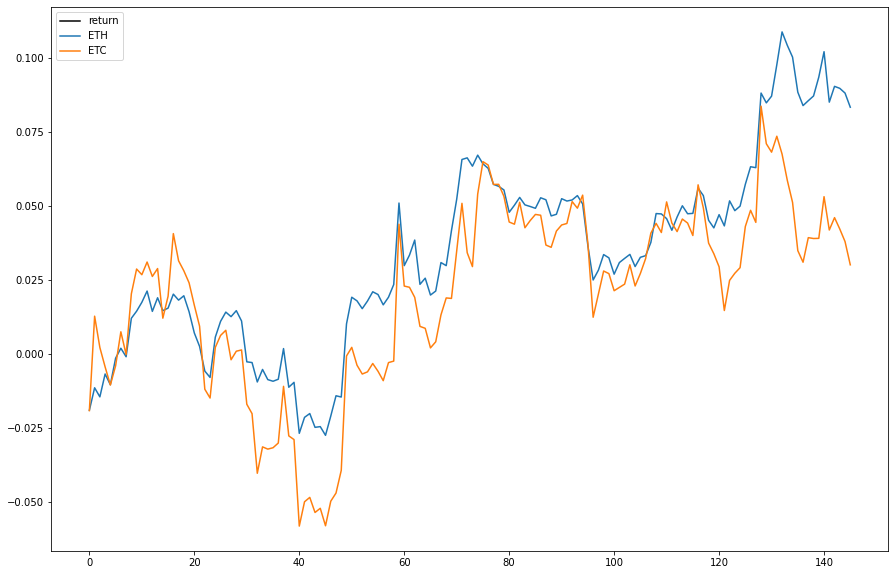

In [6]:

def multi_weighted_index(weights, lookback_window , resolution="1h"):
    """
    Multiweighted index visualizer
    weights - dictionary of tickers with respective weights (negative weight indicates short)
    lookback_window - lookback period in days
    starting_balance - starting balance
    """
    start_date = date.today() - timedelta(lookback_window)
    ohlc_data = dict()
    holding = dict()
    returns = pd.DataFrame()
    for ticker in weights.keys():
        try:
            ohlc = read_historical_data(start_date, f"{ticker}-PERP", resolution)
        except FileNotFoundError as e:
            ohlc_filename = download_historical_data(start_date, f"{ticker}-PERP", resolution)
            ohlc = read_historical_data(start_date, f"{ticker}-PERP", resolution)
        
        ohlc[f"return_{ticker}"] = (ohlc['close'] - ohlc['open'][0]) / ohlc['open'][0]
        returns[ticker] = ohlc[f"return_{ticker}"]

    for k,v in weights.items():
        returns[k].apply(lambda x: x*v)
    print(returns.iloc[0:,-1: ].sum(axis=1))
    returns["cum_returns"] = returns.iloc[:,-1: ].sum(axis=1)
    # need to fix here
    # cum_returns = asset return * weight 
    remove_data()

    plt.figure(figsize=(15,10))
    plt.plot(returns["cum_returns"], color='black', label='return')
    for ticker in weights.keys():
        plt.plot(returns[ticker], label=ticker)
    plt.legend()


    return returns

    
multi_weighted_index({"ETH":1, "ETC":1}, 5)


           ETC
0    -0.004796
1    -0.015816
2    -0.035597
3    -0.031197
4    -0.027015
...        ...
1495 -0.023804
1496 -0.024002
1497 -0.025766
1498 -0.020375
1499 -0.018829

[1500 rows x 1 columns] hi


,ETH,ETC,cum_returns
0,-0.004408,-0.004796,-0.004796
1,-0.002917,-0.015816,-0.015816
2,-0.011669,-0.035597,-0.035597
3,-0.009659,-0.031197,-0.031197
4,-0.007844,-0.027015,-0.027015
...,...,...,...
1495,-0.018735,-0.023804,-0.023804
1496,-0.018994,-0.024002,-0.024002
1497,-0.018735,-0.025766,-0.025766
1498,-0.016336,-0.020375,-0.020375


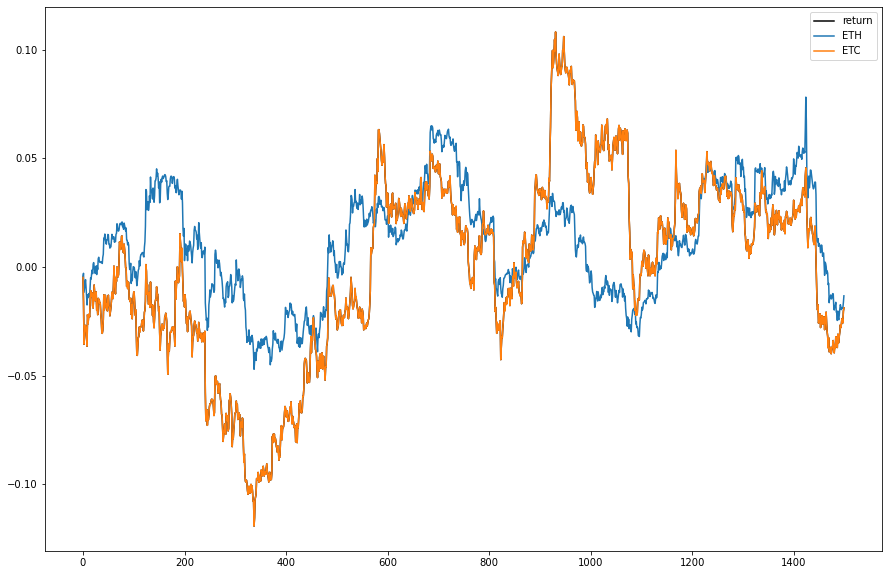

          ETH    SRM
0    0.004660 -0.002
1    0.000575  0.003
2   -0.001036  0.003
3    0.001553  0.002
4    0.000805  0.005
..        ...    ...
546 -0.012082 -0.026
547 -0.013636 -0.024
548 -0.012657 -0.023
549 -0.012082 -0.023
550 -0.011564 -0.023

[551 rows x 2 columns]


,ETH,SRM,cum_returns
0,0.004660,-0.002,-0.002
1,0.000575,0.003,0.003
2,-0.001036,0.003,0.003
3,0.001553,0.002,0.002
4,0.000805,0.005,0.005
...,...,...,...
546,-0.012082,-0.026,-0.026
547,-0.013636,-0.024,-0.024
548,-0.012657,-0.023,-0.023
549,-0.012082,-0.023,-0.023


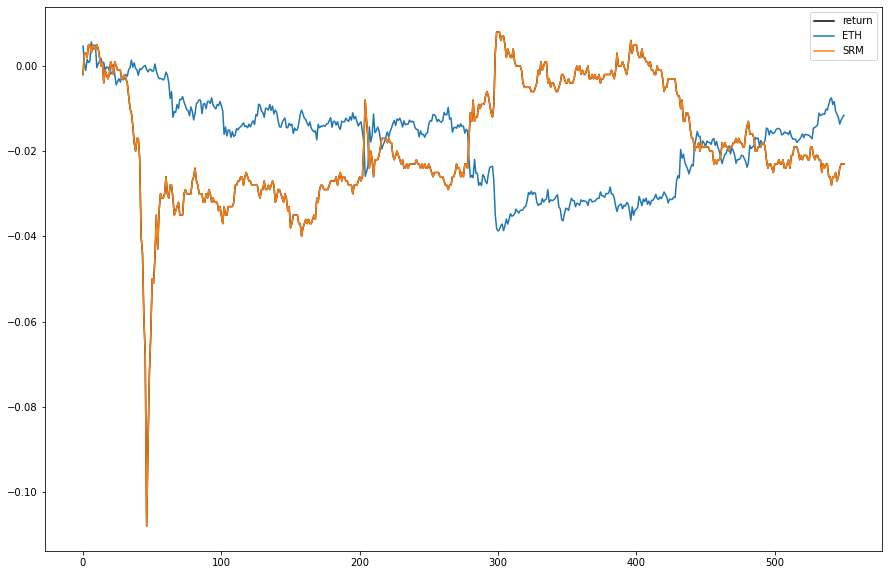

In [1]:
from pairs_helper_functions import *
multi_weighted_index({ "ETH":1,  "SRM":-1}, 1, resolution="5m")

In [146]:
download_historical_data("2022-07-01", "SOL-PERP", "1h")

'SOL-PERP_1h_2022-07-01.csv'

In [169]:
from oms import OMS
from csv import writer
import time
o = OMS()

with open('pnl.csv', 'a') as f_object:
  
    # Pass this file object to csv.writer()
    # and get a writer object
    writer_object = writer(f_object)
  
    # Pass the list as an argument into
    # the writerow()
    pnl, pos = o.pnl()
    print(pnl)
    writer_object.writerow([pnl])
  
    #Close the file object
    f_object.close()


0.0


In [1]:
from oms import OMS
o = OMS()


In [5]:

def chase(markets):
    bid_ask = o.bid_ask(markets)
    for ticker, side in markets:
        if side == "buy":
            o.oms.create_limit_order(symbol=ticker + "-PERP", side=side, amount=size, price = bid_ask[ticker][0])
        else:
            o.oms.create_limit_order(symbol=ticker + "-PERP", side=side, amount=size, price = bid_ask[ticker][1])
chase(markets={"SOL":"buy"})

{'SOL': ('39.5275', '39.53')}


In [ ]:
"""baskets
Majors: BTC ETH SOL AVAX 
Alt L1: SOL AVAX ONE OP ETC BCH SNX
Dinos: AAVE MKR LDO 
NFTs: LOOKS APE 
Alt Sol: SRM RAY 



"""